In [1]:
# -*- coding: utf-8 -*-
#import skbeam
import sys
import os

scripts_path = os.path.join(os.path.abspath('..'), 'scripts')

sys.path.append(scripts_path)
import clustering_function_file as clst

from skbeam.core import correlation as corr
#import skbeam
import skbeam.core.roi as roi
import skbeam.core.utils as utils


import pickle as pickle
import matplotlib.pyplot as plt
import numpy as np

import cv2
from skimage.util import img_as_float, img_as_ubyte


import pandas as pd 

import re
from pandas.plotting import autocorrelation_plot
import multipletau
from tqdm.notebook import trange, tqdm
from skimage import measure, color, io
from skimage.util import img_as_float, img_as_ubyte

from scipy import ndimage
from PIL import Image
from scipy.stats import t
from statsmodels.tsa.stattools import adfuller


## **Load data file**
* **The following calcualtions were conducted using photon arrival data whose size is around 5 GB or (30 minute experiment duration).** 
* **The data file 'SampleShortData.csv' is attached for demonstration purpose, which contains 1000 photon arrival data with a 20 ms experiment duration.** 




In [2]:
data_folder_path = os.path.join(os.path.abspath('..'), 'data')
# This adds the 'scripts' folder to the list of paths Python looks in for modules
if data_folder_path not in sys.path:
    sys.path.append(data_folder_path)
filename =  r'SampleData.csv'  #r'SampleShortData.csv'
file_path = os.path.join(data_folder_path, filename)

data_raw = pd.read_csv(file_path)


In [3]:
data_raw.head()

,1did,t
0,230728,814
1,228704,900
2,228703,900
3,134059,917
4,133548,917


## The columns represent the detector coordinates of the photons and their arrival times.
* **'1did' is the x,y coordiante saved in one number to save space.  't' is the time stamp in 200ns**
*  **1did = y * 512 + x**
*  **x = 1did % 512 and  y = 1did // 512**
*  **Photon arrival time  = (t * 200 ) ns**

* **Sort Data based based on photon arrival times**
*  **'photon_df': DataFrame where all the photon timestamps are grouped by thier coordinates.**
*  **'summed_image': Represents the total number of photons at each pixel for the experiment duration.**


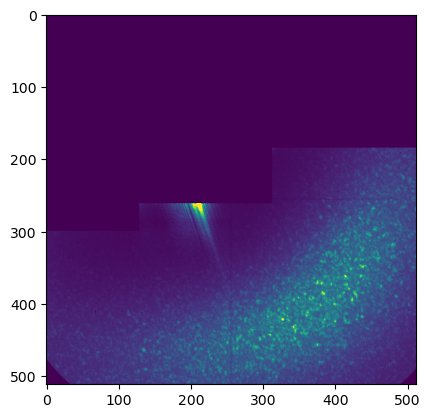

In [4]:
data_sorted = data_raw.sort_values(by = 't', ascending = True)
photon_df, summed_image = clst.imager_mask_remover(data_sorted , 0, 10000) # 0 and 1000 are used to set the contrast level 

## All the time stamps are grouped by their x,y coordinates

In [5]:
photon_df.head()

,1did,PhNo,ts,x,y
0,300,726.0,"[3493196, 17416202, 21296648, 34077299, 397433...",300,0
1,301,725.0,"[6141862, 21296648, 29700320, 39743391, 446567...",301,0
2,302,703.0,"[6141862, 8227237, 29700320, 34001623, 3563869...",302,0
3,303,657.0,"[1551955, 8227237, 34001623, 35638695, 4100446...",303,0
4,304,613.0,"[8227237, 21504215, 30915686, 41004464, 655360...",304,0


# q-ring selection
* **Create a q-ring which is basically an ROI. The goal is to select all the data (photon timestamps and coordiantes) within the q-ring.**
* **Input various experimental parameters**


In [6]:

experimental_parameters = {'center_beam': (201,213),
                          'distance': 1,
                          'rad_ini': 0.014,
                          'rad_fin': 0.016,
                          'agrid_ini': 0.4,
                          'agrid_fin': 1.3
                          }

## First, let's see the q-ring
* **vm1 and vm2 are to change the contrast levels in the image.**
* **The q-ring is highlighted**

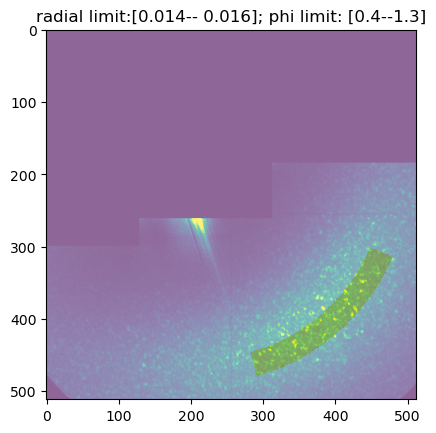

In [7]:
q1 = clst.q_roi_viewer_new(summed_image,  vm1 = 800, vm2 = 8000, **experimental_parameters,)

### Now, extract all the data (photon timestamps, coordinates) for the photons that had arrived within the q-ring

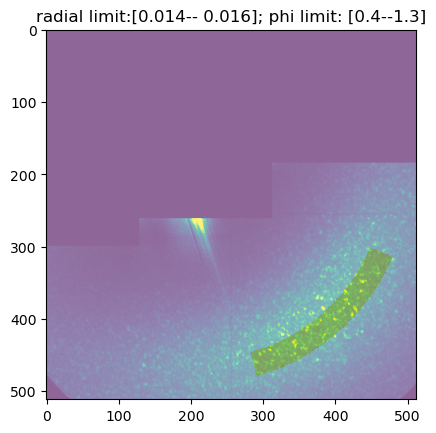

In [8]:
q1_only_timestamps, q1_all_data_df =clst.timestamps_from_ring_movie(photon_df, summed_image, vm1 = 800, vm2 = 8000,
                                       **experimental_parameters
                        )

### q1_all_data_df stores photon coordinates and arrival times grouped by coordinates

In [9]:
q1_all_data_df.head()

,1did,ts
0,144831,"[5688730, 7523348, 9460408, 10683710, 10803858..."
1,144832,"[2670810, 7523348, 9460408, 10803858, 11352974..."
2,144833,"[1453159, 4593244, 5667234, 9039239, 10151213,..."
3,145342,"[406913, 3539627, 6671935, 10018699, 11244872,..."
4,145343,"[2670810, 4210357, 6551369, 6671935, 9460408, ..."


### We are going to detect speckles within the q-ring. It is needed to normalize the q-ring image.
* **We will output the normalized q-ring image, the unnormalized image, and perform some operations on the q1_all_data_df and save it as q1_df**

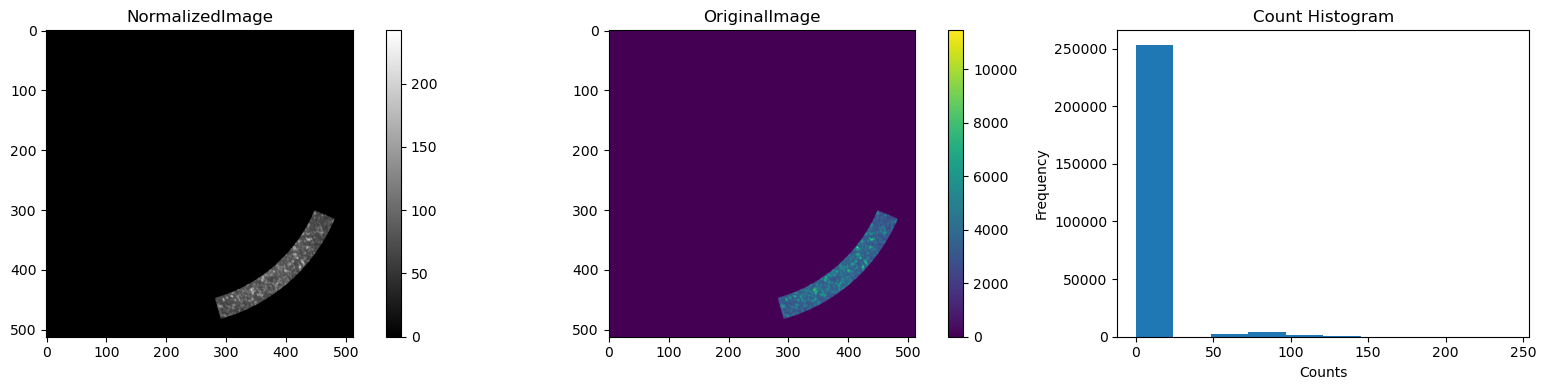

In [10]:
q1_image_norm, q1_image, q1_df = clst.qring_image_for_speckle_detection(q1_all_data_df)


In [11]:
q1_df.head()

,1did,ts,PhNo,x,y
0,144831,"[5688730, 7523348, 9460408, 10683710, 10803858...",2667,447,282
1,144832,"[2670810, 7523348, 9460408, 10803858, 11352974...",3283,448,282
2,144833,"[1453159, 4593244, 5667234, 9039239, 10151213,...",3027,449,282
3,145342,"[406913, 3539627, 6671935, 10018699, 11244872,...",3469,446,283
4,145343,"[2670810, 4210357, 6551369, 6671935, 9460408, ...",2974,447,283


### Identify the speckles.
* **The goal is to identify the speckle coordiantes.**
* **The normalized image is smoothed with a Gaussian Filter.(3,3) and 0 are the kernel size and standard deviation** 
*  **Play with the threshold value to find the sweet spot in speckle detection. In this case it is 100.**
*  **Select the minimum and maximum size of the speckles that would be considered.**

# Identify speckles
* **The green marks in the middle figure represent speckles.**
* **The histogram gives an idea of the speckle size distribution**

Area of Each Speckle: [5.5, 0.5, 3.0, 0.0, 1.5, 0.0, 15.5, 28.5, 11.5, 0.0, 1.5, 9.5, 13.0, 26.0, 0.0, 9.5, 0.0, 2.0, 12.5, 31.5, 4.5, 0.0, 4.0, 3.0, 0.0, 14.5, 56.0, 78.0, 3.0, 1.0, 16.0, 2.0, 0.0, 6.5, 3.5, 1.5, 9.5, 6.0, 3.0, 79.5, 6.5, 0.0, 1.0, 3.5, 135.0, 6.0, 27.5, 110.5, 0.0, 0.5, 42.0, 3.0, 49.0, 1.0, 1.0, 0.5, 55.0, 5.5, 1.0, 0.0, 20.5, 0.0, 39.0, 1.5, 0.0, 2.0, 15.5, 36.0, 13.0, 8.5, 0.5, 21.0, 0.5, 1.0, 7.5, 11.5, 1.0, 0.0, 0.5, 6.5]
Total No of identified Speckles 80
No of Chosen Speckles: 46


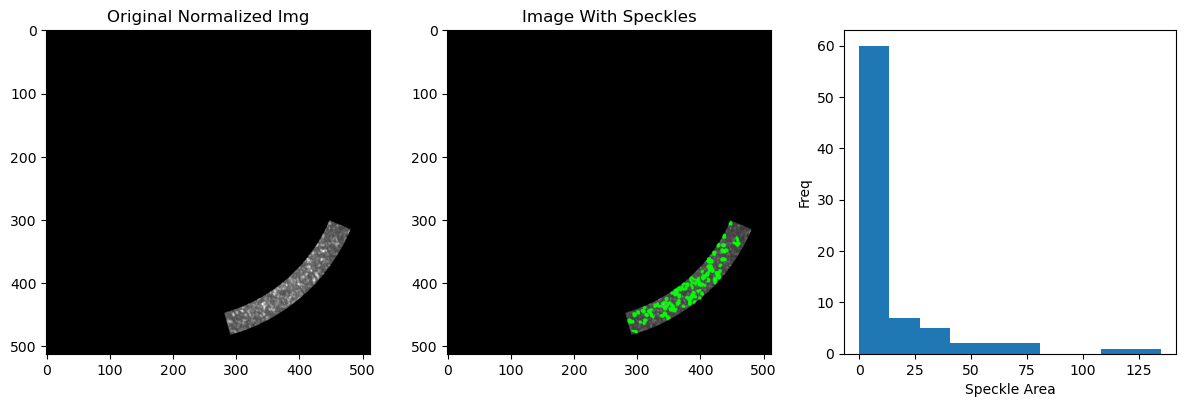

In [12]:
output_image, speckles, areas = clst.speckle_finder_cv2(q1_image_norm, (3,3), 0,  100, 2, 150)
print('Area of Each Speckle:', areas)
print('Total No of identified Speckles', len(areas))
print('No of Chosen Speckles:',len(speckles))
%matplotlib inline
#fig, ax = plt.subplots(2,2, figsize = (9,6))
plt.figure(figsize = (12,4))
plt.subplot(131)
plt.imshow(q1_image_norm, cmap = 'gray', vmin = 0, vmax = 200)
plt.title('Original Normalized Img')
plt.subplot(132)
plt.imshow(output_image, vmin = 0, vmax = 200)
#plt.title('speckle_finder_cv2_wBlurring')
plt.title('Image With Speckles')
plt.subplot(133)
plt.hist(areas)
plt.xlabel('Speckle Area')
plt.ylabel('Freq')
#plt.yscale('log')
plt.tight_layout()

# Autocorrelation calculation 
* **First, we collect all the photon timestamps arrived within each speckle.**
* **Second, Bin the timestamps in bins of say 1s duration (user defined bin width). This creates a time series.**
* **Third, calculate the autocorrelation function for the time series. Used pandas_acf**
* **Used adfuller method to check if the time series' are stationary.**
* **For the calculation, provide the speckle coordinates (speckles), normalized image (q1_image_norm), all the photon data (photon_df).**
*  **To create 1s bins, divide the timestamps  by 1e9.**
*  **Each bin is 1s.**
*  **0.05 is the tolerance for adfuller test for stationarity.**

No. of bins:  858 EachBinDuration (sec):  1.001097303
No. of bins:  858 EachBinDuration (sec):  1.00112439
No. of bins:  858 EachBinDuration (sec):  1.001125616
No. of bins:  858 EachBinDuration (sec):  1.001117949
No. of bins:  858 EachBinDuration (sec):  1.001126443
No. of bins:  858 EachBinDuration (sec):  1.001069752
No. of bins:  858 EachBinDuration (sec):  1.00111636
No. of bins:  858 EachBinDuration (sec):  1.001132163
No. of bins:  858 EachBinDuration (sec):  1.001120703
No. of bins:  858 EachBinDuration (sec):  1.001107278
No. of bins:  858 EachBinDuration (sec):  1.001129552
No. of bins:  858 EachBinDuration (sec):  1.001086117
No. of bins:  858 EachBinDuration (sec):  1.001096144
No. of bins:  858 EachBinDuration (sec):  1.001086613
No. of bins:  858 EachBinDuration (sec):  1.001114151
No. of bins:  858 EachBinDuration (sec):  1.001133888
No. of bins:  858 EachBinDuration (sec):  1.001131509
No. of bins:  858 EachBinDuration (sec):  1.0011044
No. of bins:  858 EachBinDuratio

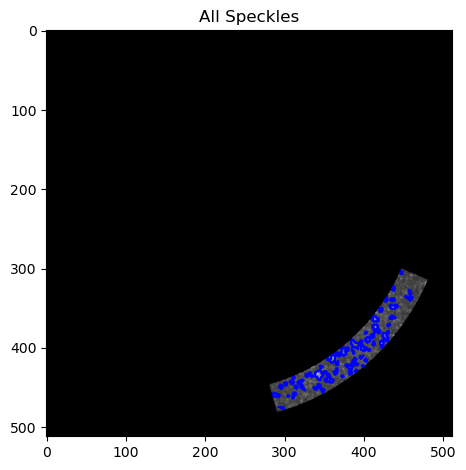

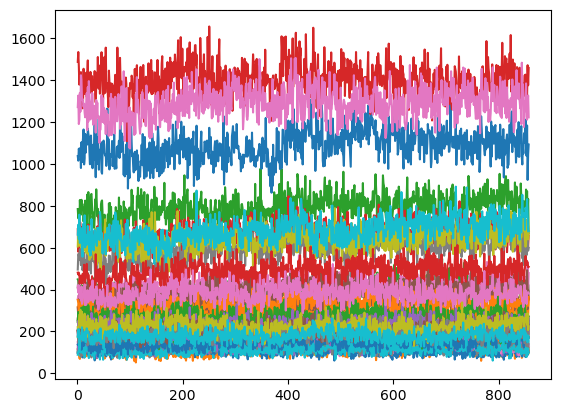

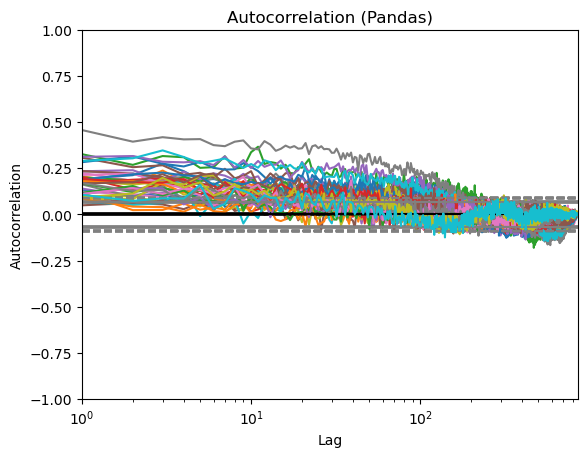

In [13]:
q1_bin, q1_pandas, q1_mpt, q1_spdict, q1_allspeckles =  clst.ac_calculator_speckles_onlystationary(speckles, 
                                                                            q1_image_norm, photon_df,  1e9, 1, 0.05)



### Stored the results of the autocorrelation calculations in a dictionary. Each key represents a speckle.

In [14]:
q1_pandas[0].head()

,lag,ac
0,1,0.191264
1,2,0.211901
2,3,0.274644
3,4,0.233561
4,5,0.185559


### Calculate the confidence interval for the autocorrelation calcualtion. It's the dashed gray lines in the ACF plot. A curve within the confidence interval indicates that there's no siginificant correlations present. 

In [15]:
# calculate the z value,.i.e., the horizontal line in the acf plots
# Formula ci95 = z95/np.sqrt(N), z95 = 1.96, z99 = 2.57
ci95 = np.round(1.96 / np.sqrt(q1_bin[0].dropna().shape[0]),3)
ci95

0.067

### It's possible to plot all the ACF curves using Bokeh, and slide through them. 
* It will open another borwser window.


In [ ]:
all_q1250_bokeh = clst.bokeh_plotter(
    [val['ac'].values for key,val in q1_pandas.items()],
    q1_pandas.keys(),
    q1_pandas[0]['lag'].values)

## Find the speckles with significant correlations
* **Some speckles show significant correlations and some don't.**
* **We will go through all the ACFs and see which ones are above the confidence interval (CI)**.
* **Let's denote the ACFs (and the speckles) above the CI as dynamic speckles**.
* **Dynamic speckles are shown by green marks on the top right figure.**
* **The bottom panel shows the average of all ACFs for dyanmic speckles, as well as the individual ACF curves.**

dict_keys([0, 1, 3, 15, 17, 18, 24, 28, 29, 31, 34])


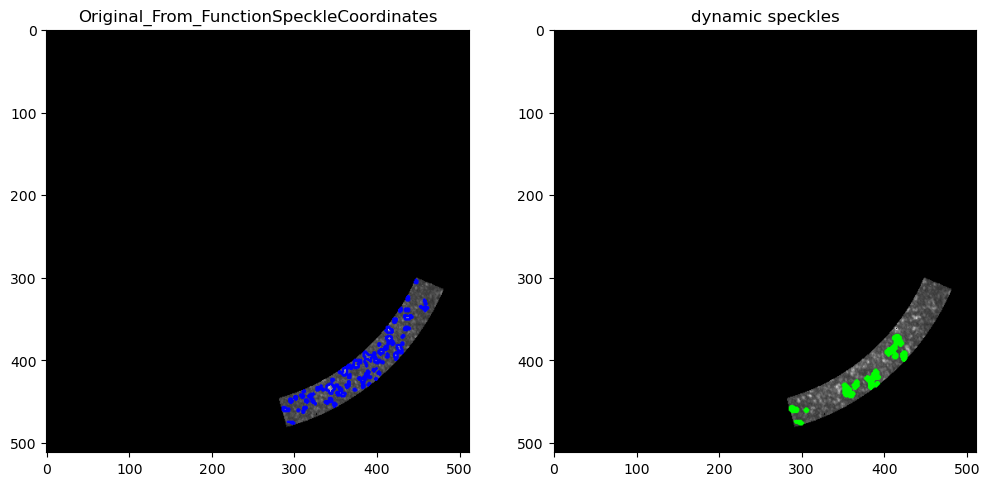

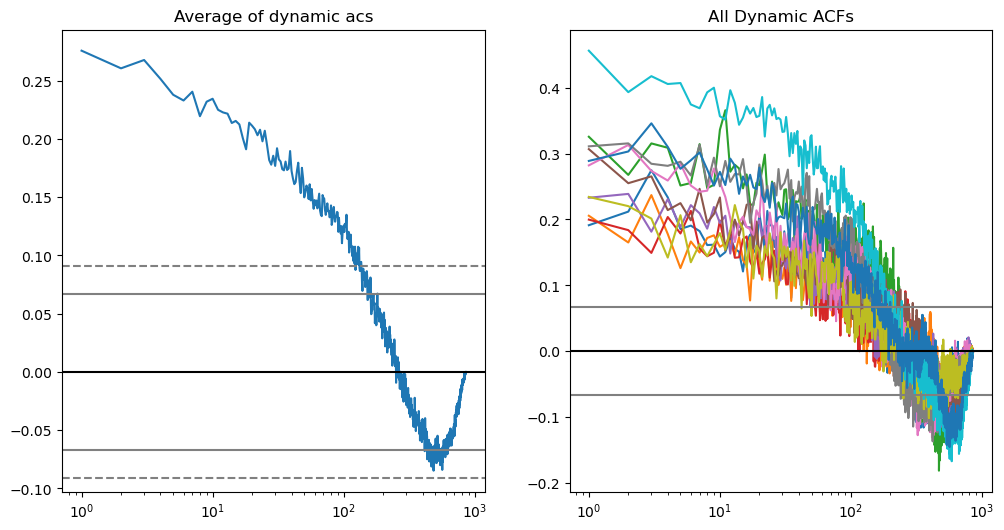

In [16]:
q1_dynamic_ac, q1_dynamic_dict, q1_dynamic_coords, q1_dynamic_ci, q1_avg_ac  = clst.dynamic_speckle_finder_3(q1_pandas, q1_spdict, 
                                                                                                q1_image_norm,  q1_allspeckles, 200, ci95 )


## The results can be output through pickle or writing into a csv file. 

In [ ]:
q1_par = [0.014,0.016,0.4,1.3]


In [ ]:
out_test = pd.DataFrame({ 
        'q1':{'q1_coord': q1_par, 'q1_image_norm': q1_image_norm , 'q1_bin': q1_bin, 'q1_pandas': q1_pandas, 'q1_mpt': q1_mpt, 'q1_spdict': q1_spdict, 'q1_allspeckles': q1_allspeckles ,
                          'q1_avg': q1_avg_ac, 'q1_misc': [1e9, 1],
             'q1_dynamic_ac': q1_dynamic_ac, 'q1_dynamic_coords': q1_dynamic_coords, 'q1_dynamic_ci': q1_dynamic_ci}}
                     )

In [ ]:
#with open('{}{}'.format('sample_result_file','.pkl' ), 'wb') as outfile:
#    pickle.dump(out_test, outfile, pickle.HIGHEST_PROTOCOL)
#outfile.close()

In [93]:
def flatten(xss):
    return [x for xs in xss for x in xs]
#scale = 1000
#m = 1
#segments = np.floor(len(X)/scale)
#print(segments)

######### Create a function to dela with one scale. Use this function in loop for many scales
def one_segment(time_series, scale, m_order):
    segments = np.floor(len(time_series)/scale)
    X_Idx_list = []  # time series
    C_list = []
    fit_list = []
    RMS_list = []
    Index_list = []
    for i in range(int(segments)):
        Idx_start = i * scale
        Idx_stop = (i+1)* scale
        Index = np.arange(Idx_start, Idx_stop, 1)
        X_Idx = time_series[Idx_start: Idx_stop]
        C = np.polyfit(Index, X_Idx, m_order)
        fit = np.polyval(C, Index)
        RMS = np.sqrt(np.mean( (X_Idx - fit)**2 ))
        X_Idx_list.append(X_Idx)
        C_list.append(C)
        fit_list.append(fit)
        RMS_list.append(RMS)
        Index_list.append(Index)
    F = np.sqrt(np.mean( (np.array(RMS_list))**2 ))
    return Index_list, X_Idx_list, fit_list, RMS_list, F

########### calculate q dependent rms
######### Create a function to dela with one scale. Use this function in loop for many scales
def one_segment_q(time_series, scale, m_order):
    segments = np.floor(len(time_series)/scale)
    X_Idx_list = []  # time series
    C_list = []
    fit_list = []
    RMS_list = []
    Index_list = []
    for i in range(int(segments)):
        Idx_start = i * scale
        Idx_stop = (i+1)* scale
        Index = np.arange(Idx_start, Idx_stop, 1)
        X_Idx = time_series[Idx_start: Idx_stop]
        C = np.polyfit(Index, X_Idx, m_order)
        fit = np.polyval(C, Index)
        RMS = np.sqrt(np.mean( (X_Idx - fit)**2 ))
        X_Idx_list.append(X_Idx)
        C_list.append(C)
        fit_list.append(fit)
        RMS_list.append(RMS)
        Index_list.append(Index)
    #RMSq = [np.array(RMS_list)**qs[j] for j in range(len(qs))]
    #F = [np.mean(RMSq)**(1/qs[j]) for j in range(len(qs)) ]
    return Index_list, X_Idx_list, fit_list, RMS_list

#dictin = res_250K30min['q1']['q1_bin']
def dfa_one_q_iterator(dict_in, scales_in, signal_process = True, m_order = 1, fa = 0, fb = -1 ):
    F1_dict = {}
    rms_dict = {}
    for key,val in dict_in.items():
        if signal_process is True:
            Y = np.cumsum( val['bins'].dropna().values - np.mean(val['bins'].dropna().values))
        elif signal_process is False:
            Y = val['bins'].dropna().values
        F_list = []
        rms_list = []
        for i in range(len(scales_in)):
            x12, y12, fit12, rms12, F12 = one_segment(Y, scales_in[i], m_order)
            F_list.append(F12)
            rms_list.append(rms12)
        F_fit, F_fit_err = np.polyfit(np.log2(scales_in[fa:fb]), np.log2(F_list[fa:fb]), 1, cov = True)
        F_fit_y = np.polyval(F_fit, np.log2(scales_in[fa:fb]))
        final_error = np.sqrt(np.diag(F_fit_err))
        F1_dict[key] = {'F':F_list, 'F_fit_y':F_fit_y,  'slope': np.round(F_fit[0],3), 'intercept': np.round(F_fit[1],3), 
                        'slope_err': np.round(final_error[0],3), 'intercept_err': np.round(final_error[1],3)}
        rms_dict[key] = {'rms':rms_list}
    
    all_slopes = [val3['slope'] for key3,val3 in F1_dict.items()]
    all_slopes_err = [val4['slope_err'] for key4,val4 in F1_dict.items()]
    avg_slope = np.round(np.average(all_slopes),3)
    std_slope = np.round(np.std(all_slopes),3)
    error_plot_x = list(F1_dict.keys())
    
    plt.figure(figsize = (16,6))
    plt.subplot(121)
    for key1, val1 in F1_dict.items():
        plt.plot(np.log2(scales_in[fa:fb]), np.log2(val1['F'][fa:fb]), 'o', label = '{}'.format(key1))
        plt.plot(np.log2(scales_in[fa:fb]), val1['F_fit_y'], '-', lw = 3)
    plt.xlabel('log2 (scales)')
    plt.ylabel('log2 F')
    plt.subplot(122)
    plt.errorbar(error_plot_x, all_slopes,
                                yerr = all_slopes_err, fmt = 'ko', ms = 10,
            linewidth=2, capsize=8)
    plt.xlabel('Speckle Index')
    plt.ylabel('Slope w/ err')
    
    return F1_dict, rms_dict, [avg_slope, std_slope] 
            

# Detrended Fluctuation Analysis (DFA)
### After identifying all the speckles, now we can create photon time series for each speckles. We can perform DFA on these speckle time series to calculate the Hurst exponent. The analysis process is explained later in the notebook step by step.
* **We are going to iterate through all the speckle time series and calculate Hurst exponents.** 

In [18]:
scmin = 8
scmax = 128
scres = 19
exponents = np.linspace(np.log2(scmin), np.log2(scmax), scres)
scale_test = np.round(2**exponents)
scale_test.astype(int)
scales = scale_test.astype(int) #[8, 16, 32, 64, 128, 256,512]

[0.653, 0.057]
[0.691, 0.641, 0.697, 0.565, 0.668, 0.639, 0.625, 0.652, 0.666, 0.568, 0.551, 0.552, 0.658, 0.677, 0.681, 0.723, 0.666, 0.6, 0.561, 0.699, 0.779, 0.613, 0.593, 0.769, 0.632, 0.619, 0.654, 0.676, 0.729, 0.698, 0.64, 0.67, 0.716, 0.59, 0.633, 0.728, 0.706, 0.626, 0.681, 0.588]


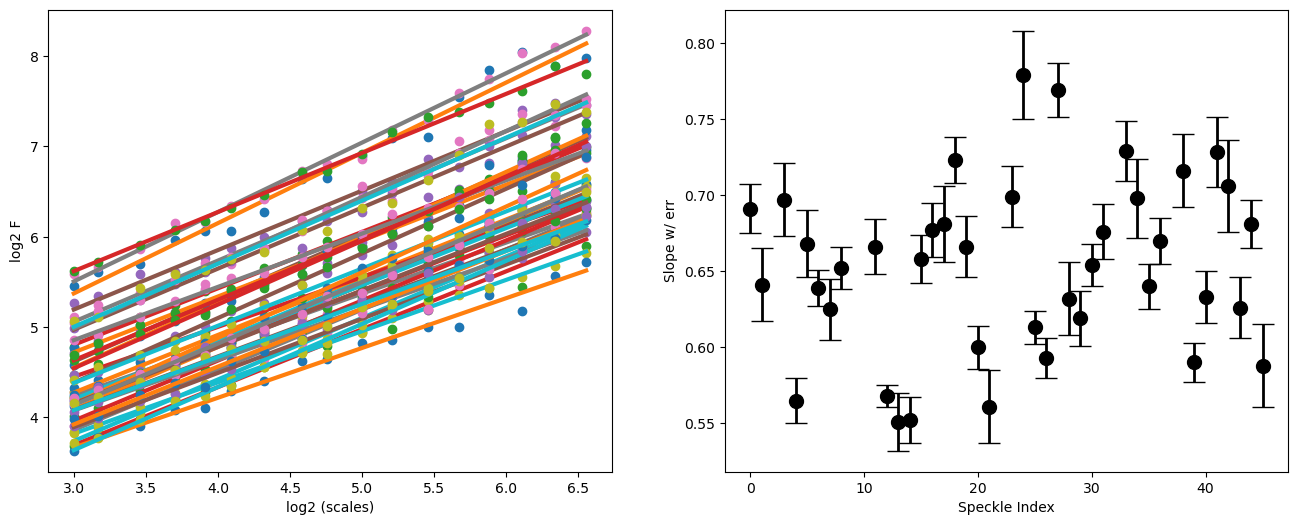

In [19]:
F_dict, rms_dict, slopes  = clst.dfa_one_q_iterator(q1_bin, scales, signal_process = True, m_order = 1,
                                                         fa = 0, fb = -2)
print(slopes)
all_slope = [val['slope'] for key,val in F_dict.items()]
print(all_slope)

## Hurst exponent for each speckle time series is calcualted.  
### The slope for each straight line in the above figure is the corresponding Hurst exponent for the time series. The Hurst exponents are shown in the right figure. 
### A box and whisker plot will be a better choice for visualization. 

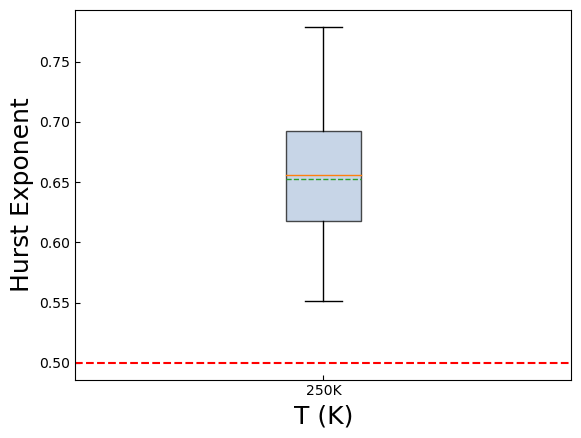

In [20]:
fig, ax = plt.subplots()
box_properties = dict(facecolor='lightsteelblue', alpha=0.7)
ax.boxplot(all_slope, labels = ['250K'] , 
            showmeans=True, meanline=True, patch_artist=True, boxprops = box_properties)
ax.axhline(y = 0.5, color = 'red', linestyle = '--')
ax.set_ylabel('Hurst Exponent', fontsize = 18)
ax.set_xlabel('T (K)', fontsize = 18)
ax.tick_params(axis='both', which='both',direction = 'in')

## It is known that when
* **H > 0.5 : Persistent/trending time series**
* **H = 0.5 : Random walk Like**
* **H < 0.5 : Mean revering time series**
## Since the Hurst exponents are all greater than 0.5, they all represent a persistent or trending behavior. This is connected with the presence of magnetic interactions.** 

## The steps towards the claculations is explained further below.

# Detrended Flucturation Analysis 
### Based on the work by 
[Espen A. Ihlen, “Introduction to multifractal detrended fluctuation analysis in matlab,” Frontiers in
Physiology Volume 3 - 2012 (2012),]https://pmc.ncbi.nlm.nih.gov/articles/PMC3366552/
### Steps are roughly as follows:
* Step 1: Calculate the detrended profile of the time series by
$Y(i) = \sum\limits_{k=1}^{i} x_k - \langle x \rangle,  i = 1,2,....N$
* Step 2: Divide the profile into $N_s \equiv int(N/s)$ non-overlapping segments of length $s$, referred to as scale.
* Step 3: Perform a least-square polynomial fit $y_v$   to each of these segments, and calculate the variance of the difference between the data and fit to calculate the local trend: $ F^2(v,s) \equiv \frac{1}{s} \sum\limits_{i=1}^{s}\left\{Y[(v-1)s + i] 
- y_v(i)\right\}^2 $
* Step 4: Obtain the $q$-th order fluctuation function by averaging over all segments:

* $F_q \equiv \left\{\frac{1}{N_s} \sum\limits_{v = 1}^{N_s}\left[F^2(v,s)\right]^{q/2}\right\}^{1/q}$

  * Here, $q$ can take any value except $0$, for which the formula is $F_q \equiv exp\left\{\frac{1}{2N_s} \sum\limits_{v = 1}^{N_s}ln\left[F^2(v,s)\right]\right\}$
  * For $q = 2$, $F_{q=2} \equiv \left\{\frac{1}{N_s} \sum\limits_{v = 1}^{N_s}\left[F^2(v,s)\right]\right\}^{1/2}$

* Step 5: Plot log-log plots $F_q$ vs. $s$ for each value of $q$, where the scaling of the data maintains a power-law behavior with the generalized Hurst exponent $hq$ as $F_q(s) \sim s^{hq}$. For $q = 2$, it is nothing but the Hurst exponent $H$, which can be calcualted by the slope of the $F_2$ vs. $s$
plot in log-log scale. 



### Let's demonstrate the calcualtion steps for one time series. 
* Step 1: The profile of the time series is calculated.
* Setp 2: Divided the profile into say 12 chunks.
* Step 3: Perform linear fitting at each chunk; polynomial of degree 1
* Step 4: Find the q-th order fluctuation function; in this case 2nd order fluctuation function, $F_2$

Text(0.7, 0.8, '$F_2$ = 41.75')

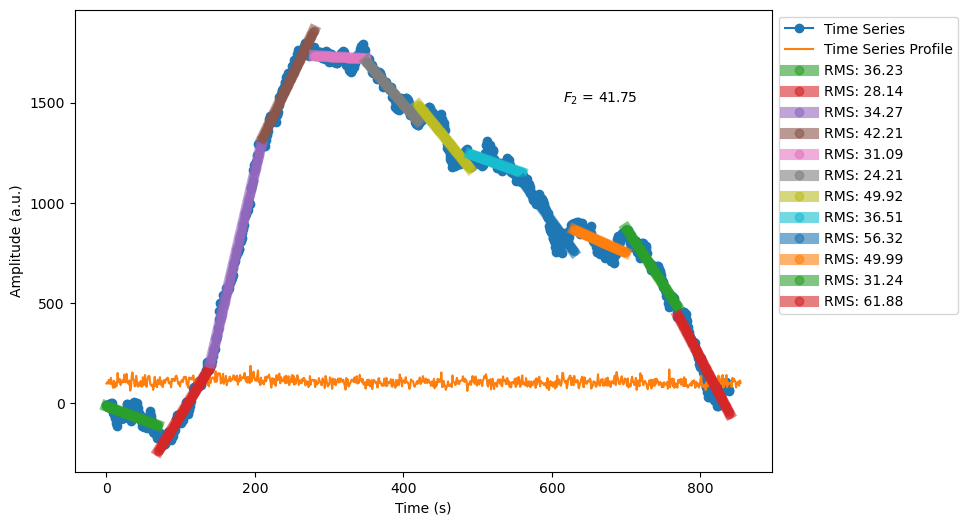

In [23]:
# Select one speckle time series
signal = q1_bin[13]['bins'].dropna().values
# Calculate the profile
profile = np.cumsum(signal - np.mean(signal))
# Divide the profile into chunks, perform linear fit, and other calculations
index_of_chunks, y_vals_chunks, fit_values, rms_values, F_values =  clst.one_segment(profile, scale = 70, m_order = 1)
#Index_list, X_Idx_list, fit_list, RMS_list
fig, ax = plt.subplots(figsize = (9,6))
ax.plot(clst.flatten(index_of_chunks), clst.flatten(y_vals_chunks), 'o-', label = 'Time Series')
ax.plot(signal, label = 'Time Series Profile' )
#[ax.plot(index_of_chunks[i], fit_values[i], 'o-', lw = 8, alpha = 0.7, label = '{}{}'.format('RMS:',np.round(rms_values[i],3) )) for i in range(len(index_of_chunks))]
[ax.plot(idx, fits, 'o-', lw = 8, alpha = 0.6, label = f'RMS: {np.round(rms,2)}') for (idx,fits,rms) in zip(index_of_chunks, fit_values, rms_values)]
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (a.u.)')
ax.text(0.7, 0.8, f"$F_2$ = {np.round(F_values,2)}", transform = ax.transAxes )

### The profile was divided into 12 segements in the above plot, and the second order fluctuation function calculated was F2 = 41.75
* Data was divided into many other equal sized chunks (coarse graining) and the corresponding fluctuatin functions were calcualted.
* Here, we plot the coarse grained local fluctuations and the corresponding fluctuation function F2. 

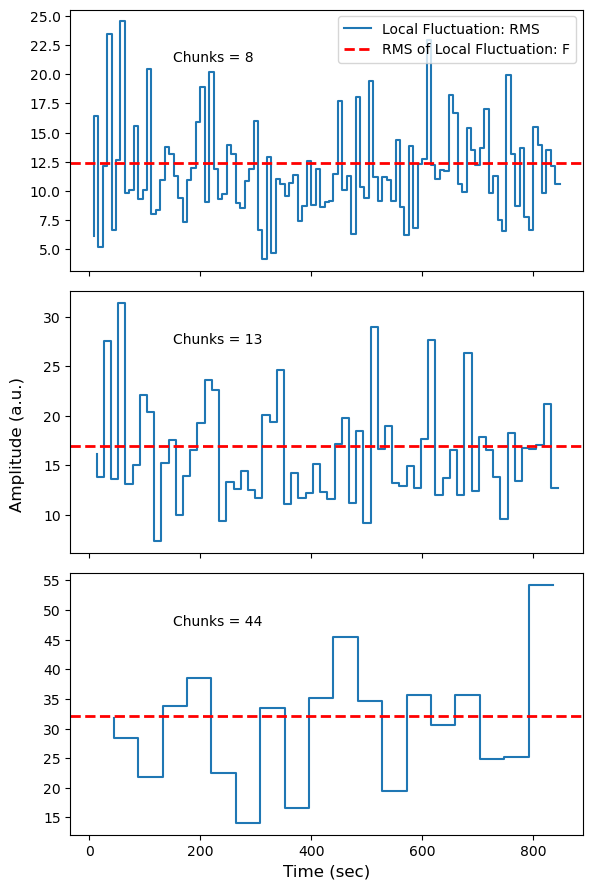

In [24]:
selected_rms_vals = rms_dict[13]['rms']
selected_F_vals = F_dict[13]['F']
data_indices = [0, 3,  11]

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 9))
for i, (ax, idx) in enumerate(zip(axes, data_indices)):
   
    x_data = np.cumsum(np.ones_like(selected_rms_vals[idx], dtype=int) * scales[idx])
    y_data = np.hstack(selected_rms_vals[idx])
    
    ax.plot(x_data, y_data, 
            drawstyle='steps-pre', 
            label= 'Local Fluctuation: RMS'  )     
    ax.axhline(y=selected_F_vals[idx], color='r', linestyle='--', lw=2, label = 'RMS of Local Fluctuation: F')
    ax.text(0.2,0.8, f'Chunks = {scales[idx]}', transform = ax.transAxes)   
    if i == 0:
        ax.legend()

axes[-1].set_xlabel("Time (sec)", fontsize=12)
fig.supylabel("Amplitude (a.u.)", fontsize=12) # A shared y-label for the whole figure
plt.tight_layout()
plt.show()


### The profile was divided into 12 segements in the above plot, and the second order fluctuation function calculated was F2 = 41.75
* Data was divided into many other equal sized chunks (coarse graining) and the corresponding fluctuatin functions were calcualted.
* Step 5: Plot $F_2$ vs scale size (or chunk size) in a log-log plot and perform a linear fit. The slope of the linear fit is the Hurst exponent.

Text(0.5, 0, 'log(Scale) ')

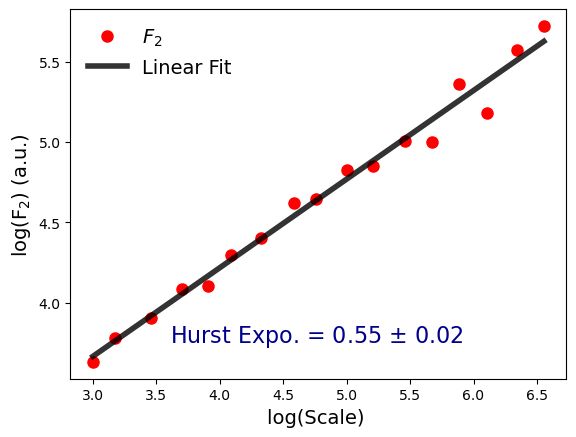

In [27]:
fig, ax = plt.subplots()
ax.plot(np.log2(scales[0:-2]), np.log2(F_dict[13]['F'][0:-2]), 'ro', ms = 8, label = '$F_2$')
ax.plot(np.log2(scales[0:-2]), F_dict[13]['F_fit_y'], 'k-', lw = 4, alpha = 0.8, label = 'Linear Fit')
ax.legend(fontsize = 14, frameon = False)
ax.text(0.2, 0.1, f"Hurst Expo. = {np.round(F_dict[13]['slope'],2)} $\pm$ {np.round(F_dict[13]['slope_err'],2) }",   fontsize = 16,
        color = 'darkblue', transform = ax.transAxes)
ax.set_ylabel('$\mathrm{log(F_2)}$ (a.u.)', fontsize = 14)
ax.set_xlabel('log(Scale) ', fontsize = 14)